![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Aprendizaje Automático

# Practica 03

# Deep Learning con Redes Neuronales Convolucionales (CNN). Transfer Learning y Métodos Ensemble. Clasificación de Imágenes con Dataset BraTS-2024

### Autor: Diego Tapia

#### Instalación e importación de librerías

In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
#import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
import nibabel as nib
import plotly.express as px

print("librerías importadas !")

2024-05-13 20:38:44.633469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 20:38:45.705500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


librerías importadas !


## Descripción del dataset

El conjunto de datos de entrenamiento proporcionado para el desafío BraTS-GoAT-2024 consiste en 2252 exploraciones de mpMRI cerebrales junto con anotaciones de segmentación de regiones tumorales. Los volúmenes 3D fueron despojados del cráneo y re-muestreados a una resolución isotrópica de 1 mm, con dimensiones de (240, 240, 155) voxels. 

Todos los escaneos mpMRI de BraTS están disponibles como archivos NIfTI (.nii.gz) y se clasifican de las siguiente forma:

* t1n: imágenes nativas 
* t1c: imágenes ponderadas en T1 post-contraste (T1Gd),
* t2w: imágenes ponderadas en T2 
* t2f: volúmenes de inversión de recuperación atenuada de fluido en T2 (T2-FLAIR), 

T1, T2 y FLAIR son secuencias o tipos específicos de imágenes que se adquieren durante un escaneo de resonancia magnética. Cada una de estas secuencias proporciona información única sobre los tejidos y las estructuras del cuerpo, y se utilizan para diferentes propósitos en el diagnóstico médico. 

T1 (Tiempo de Repetición 1):
Las imágenes T1 son sensibles a la cantidad de protones de hidrógeno presente en los tejidos y cómo están organizados. En estas imágenes, los tejidos con alto contenido de grasa aparecen brillantes, mientras que los tejidos con alto contenido de agua, como el líquido cerebroespinal, aparecen oscuros. Las imágenes T1 son útiles para resaltar la anatomía estructural, como el cerebro, los músculos y la médula espinal. También son útiles para evaluar la presencia de lesiones hemorrágicas, ya que la sangre también aparece brillante en estas imágenes.

T2 (Tiempo de Repetición 2):
Las imágenes T2 son sensibles a cómo interactúan los protones de hidrógeno entre sí y con su entorno. En estas imágenes, los tejidos con alto contenido de agua aparecen brillantes, mientras que los tejidos con bajo contenido de agua, como la grasa, aparecen oscuros. Las imágenes T2 son excelentes para detectar edema, inflamación y cambios patológicos en los tejidos. Son útiles en la evaluación de patologías como la esclerosis múltiple, tumores cerebrales y lesiones de la médula espinal.

FLAIR (Fluid Attenuated Inversion Recovery):
Las imágenes FLAIR son una variante de las imágenes T2 que suprimen la señal del líquido cerebroespinal (CSF, por sus siglas en inglés) para mejorar la visualización de las estructuras periventriculares y subcorticales del cerebro. Al suprimir la señal del CSF, las imágenes FLAIR pueden mejorar la detección de lesiones cerebrales y proporcionar una mejor diferenciación entre la sustancia blanca y la sustancia gris en el cerebro. Son útiles en el diagnóstico de enfermedades como la esclerosis múltiple, la encefalitis y las lesiones cerebrales traumáticas.

Todas estas imagenes fueron adquiridas con diferentes protocolos clínicos de múltiples instituciones contribuyentes de datos.

#### Segmentación

Todas las imágenes han sido anotadas manualmente por uno a cuatro evaluadores, siguiendo el mismo protocolo de anotación, y sus anotaciones fueron aprobadas por neurorradiólogos experimentados.

Las anotaciones para la segmentacion consisten en cuatro clases: 

* 1 para el núcleo tumoral necrótico (NCR), 
* 2 para el tejido edematoso peritumoral (ED), 
* 3 para el tumor realzante (ET) y 
* 0 para el fondo (voxels que no son parte del tumor).

![brats-segmentation](https://raw.githubusercontent.com/juandtap/ML_practica03_BraTS_2024/master/images/brats-segmentation.png)

## Análisis Exploratorio


Como se menciona anteriormente el dataset Brats cuenta con **2252** muestras de tomografías cerebrales a su vez cada muestra contiene 5 imágenes volumétricas correspondientes al tipo de mri t1n, t1c, t2w, t2f y segmentación, dando como resultado un total de **11260** imágenes volumétricas.


Nota: El dataset se carga localmente

#### Dimensiones de las imágenes volumétricas 

In [2]:
# Se imprime el shape (dimensiones) de las imagenes volumetricas
main_path = './brats_training/ISBI2024-BraTS-GoAT-TrainingData/'

sample = 'BraTS-GoAT-00007/'

brain_path = sample+'BraTS-GoAT-00007-t2f.nii.gz'
seg_path = sample+'BraTS-GoAT-00007-seg.nii.gz'

im = nib.load(main_path + brain_path).get_fdata()
seg = nib.load(main_path + seg_path).get_fdata()
print(seg.shape)
print(im.shape)


(240, 240, 155)
(240, 240, 155)


#### Visualización de una muestra 

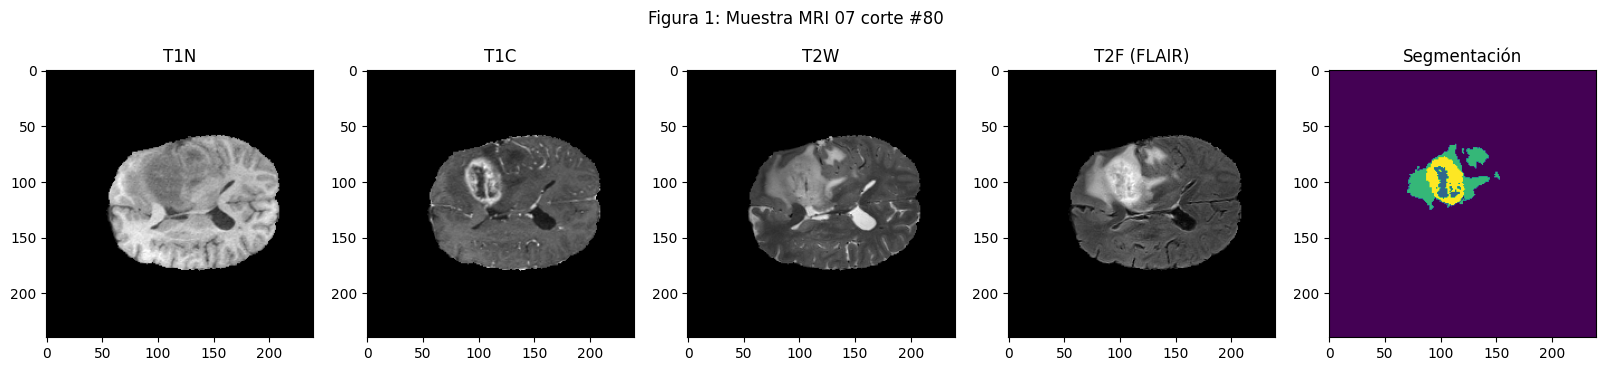

In [27]:
sample = 'BraTS-GoAT-00007/BraTS-GoAT-00007-'
sample_path = main_path+sample

# cargo las 4 images MRI y la de segmentacion
t1n_img=nib.load(sample_path + 't1n.nii.gz')
t1c_img=nib.load(sample_path + 't1c.nii.gz')
t2w_img=nib.load(sample_path + 't2w.nii.gz')
t2f_img=nib.load(sample_path + 't2f.nii.gz')
seg_img=nib.load(sample_path + 'seg.nii.gz')

# Get the image data
t1n_data = t1n_img.get_fdata()
t1c_data = t1c_img.get_fdata()
t2w_data = t2w_img.get_fdata()
t2f_data = t2f_img.get_fdata()
seg_data = seg_img.get_fdata()

# grafico el corte 
slice_nb = 80

fig, axs = plt.subplots(1, 5, figsize=(20,4))

axs[0].imshow(t1n_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1N')
axs[1].imshow(t1c_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1C')
axs[2].imshow(t2w_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2W')
axs[3].imshow(t2f_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('T2F (FLAIR)')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="viridis")
axs[4].set_title('Segmentación')

fig.suptitle('Figura 1: Muestra MRI 07 corte #80')

plt.show()